In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [2]:
# ============================================================
# 0️⃣ 경로 설정
# ============================================================
BASE_DIR = Path.cwd().resolve()
DATA_PATH = BASE_DIR.parents[1] / "data" / "raw" / "train.csv"
SAVE_PATH = BASE_DIR.parents[1] / "data" / "interim" / "train_clean.csv"


In [3]:
# ============================================================
# 1️⃣ 데이터 로드 및 타입 정리
# ============================================================
df = pd.read_csv(DATA_PATH)

df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["seq"] = df["seq"].astype(int)
df["type"] = df["type"].astype(str)
df["hs4"] = df["hs4"].astype(str).str.zfill(4)
df["weight"] = df["weight"].astype(float)
df["quantity"] = df["quantity"].astype(float)
df["value"] = df["value"].astype(int)

print(f"✅ Loaded train.csv: {df.shape}")



✅ Loaded train.csv: (10836, 9)


In [4]:
# ============================================================
# 2️⃣ 결측치 / 이상치 / 중복 처리
# ============================================================
# 1️⃣ 결측치 처리
missing_before = df.isna().sum().sum()
df = df.fillna(0)
missing_after = df.isna().sum().sum()
print(f"🧩 결측치 처리 완료: {missing_before} → {missing_after}")

# 2️⃣ 음수값 제거
before_rows = len(df)
mask_negative = (df["weight"] < 0) | (df["quantity"] < 0) | (df["value"] < 0)
negatives = df[mask_negative]
print(f"⚠️ 음수값 포함 행: {len(negatives)}건")

df = df[~mask_negative]
after_rows = len(df)
print(f"✅ 음수 제거 후: {before_rows} → {after_rows} (삭제 {before_rows - after_rows}건)")

# 3️⃣ 중복 제거
before_rows = len(df)
dup_count = df.duplicated().sum()
print(f"⚠️ 중복 행 수: {dup_count}")

df = df.drop_duplicates()
after_rows = len(df)
print(f"✅ 중복 제거 후: {before_rows} → {after_rows} (삭제 {before_rows - after_rows}건)")



🧩 결측치 처리 완료: 0 → 0
⚠️ 음수값 포함 행: 0건
✅ 음수 제거 후: 10836 → 10836 (삭제 0건)
⚠️ 중복 행 수: 0
✅ 중복 제거 후: 10836 → 10836 (삭제 0건)


In [5]:
# ============================================================
# 3️⃣ 자동 리포트 (결측, 중복, 이상치 등)
# ============================================================
print("\n📊 전처리 품질 리포트\n" + "="*50)

# (1) 결측치 요약
missing = df.isna().sum()
missing_rate = (missing / len(df) * 100).round(2)
report = pd.DataFrame({"MissingCount": missing, "MissingRate(%)": missing_rate})

# (2) 중복 행 수
duplicates = len(df) - len(df.drop_duplicates())
print(f"중복 행 수: {duplicates}")

# (3) 음수 값 검출
negatives = (df[["weight","quantity","value"]] < 0).sum()
print("\n음수 값 수:\n", negatives)

# (4) 논리 오류 (value=0인데 weight>0)
mask = (df["value"] == 0) & (df["weight"] > 0)
print(f"\nvalue=0인데 weight>0인 행 수: {mask.sum()}")

# (5) 기본 통계
print("\n기초 통계 요약 (상위 5행)\n", df.describe().T.head())

# (6) 결측률 표
print("\n결측률 요약\n", report)



📊 전처리 품질 리포트
중복 행 수: 0

음수 값 수:
 weight      0
quantity    0
value       0
dtype: int64

value=0인데 weight>0인 행 수: 1

기초 통계 요약 (상위 5행)
             count          mean           std     min      25%     50%  \
year      10836.0  2.023331e+03  1.049357e+00  2022.0  2022.00  2023.0   
month     10836.0  6.108435e+00  3.392649e+00     1.0     3.00     6.0   
seq       10836.0  2.034238e+00  8.133801e-01     1.0     1.00     2.0   
weight    10836.0  1.098413e+06  5.153790e+06     0.0   345.75  6532.5   
quantity  10836.0  8.633771e+04  7.614669e+06     0.0     0.00     0.0   

                75%          max  
year        2024.00       2025.0  
month          9.00         12.0  
seq            3.00          3.0  
weight    155510.75  110491899.0  
quantity       0.00  792598955.0  

결측률 요약
           MissingCount  MissingRate(%)
item_id              0             0.0
year                 0             0.0
month                0             0.0
seq                  0             0.0
type 

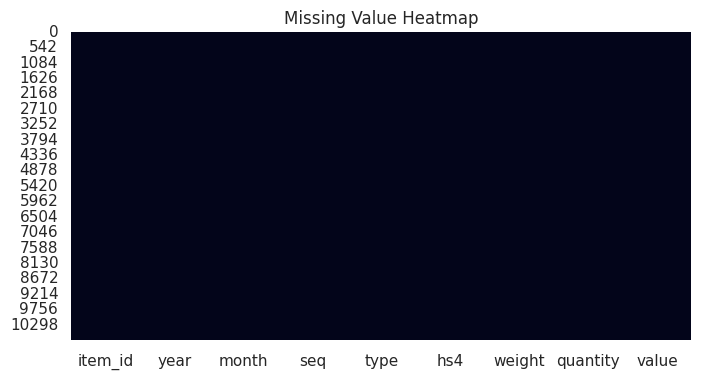

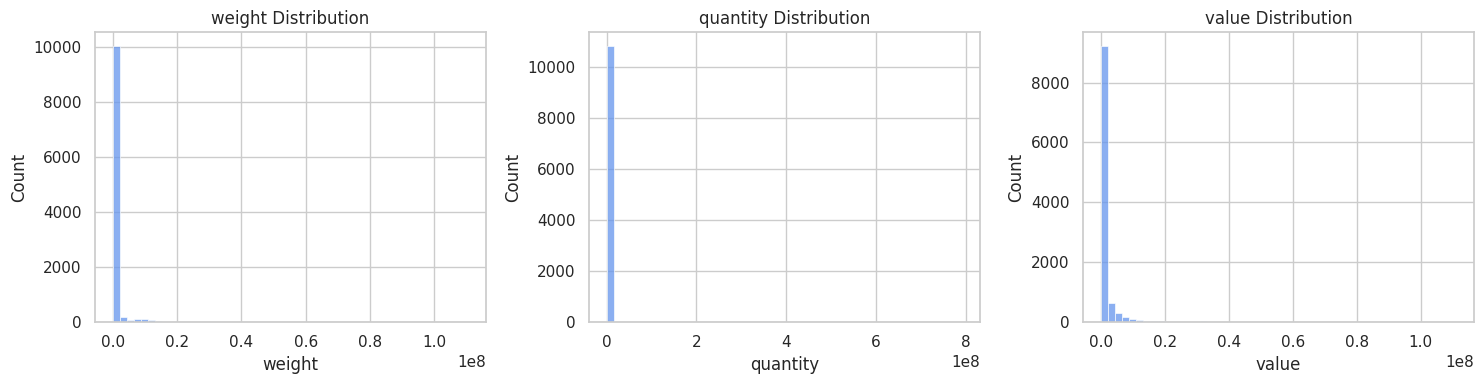

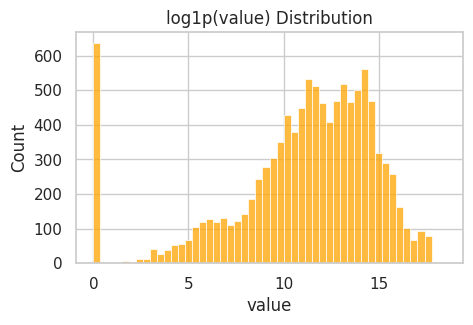

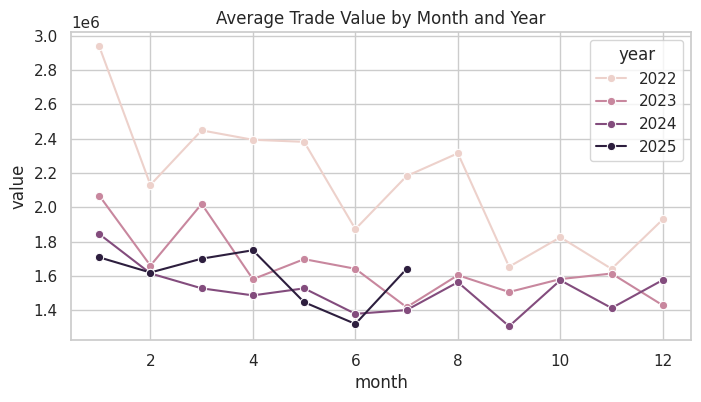

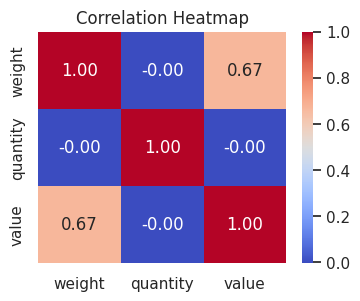

In [6]:

# ============================================================
# 4️⃣ 시각적 점검 (EDA 수준 간략 확인)
# ============================================================

sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 100})

# (1) 결측 heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

# (2) 분포 확인
num_cols = ["weight", "quantity", "value"]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, c in enumerate(num_cols):
    sns.histplot(df[c], bins=50, ax=axes[i], color="cornflowerblue")
    axes[i].set_title(f"{c} Distribution")
plt.tight_layout()
plt.show()

# (3) 로그 분포 (왜도 확인)
plt.figure(figsize=(5, 3))
sns.histplot(np.log1p(df["value"]), bins=50, color="orange")
plt.title("log1p(value) Distribution")
plt.show()

# (4) 연도별 월평균 추세
plt.figure(figsize=(8, 4))
trend = df.groupby(["year", "month"])["value"].mean().reset_index()
sns.lineplot(data=trend, x="month", y="value", hue="year", marker="o")
plt.title("Average Trade Value by Month and Year")
plt.show()

# (5) 수치형 상관관계
corr = df[["weight", "quantity", "value"]].corr()
plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [7]:

# ============================================================
# 5️⃣ 저장
# ============================================================
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(SAVE_PATH, index=False)
print(f"\n💾 Cleaned data saved to: {SAVE_PATH}")



💾 Cleaned data saved to: /data/ephemeral/home/dacon_import_pred/data/interim/train_clean.csv
